In [2]:
import torch

# Check if GPU is available
print(torch.cuda.is_available())  # Should return True if GPU is enabled

# Print the name of the GPU
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("GPU not available.")


True
Tesla T4


In [3]:
!pip install torchsampler
!pip install torchmetrics
!pip install split-folders

In [4]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
from tqdm.autonotebook import tqdm, trange
import time
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix, classification_report
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data.sampler import BatchSampler
import pandas as pd
import random
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, LeakyReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torchvision import transforms

/tmp/ipykernel_30/1900443051.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
import splitfolders

# Split the dataset into train, test, and val folders
splitfolders.ratio('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets', output="data1", seed=1337, ratio=(.7, 0.2, 0.1))

# Define the paths to train, test, and val folders
train_folder = "data1/train"
test_folder = "data1/test"
val_folder = "data1/val"


Copying files: 15000 files [01:41, 147.73 files/s]


In [6]:
train_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.ToTensor(),

])

val_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.ToTensor(),

])

test_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.ToTensor(),

])

In [7]:
train_dataset = torchvision.datasets.ImageFolder(root = train_folder, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root = val_folder, transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_folder, transform=test_transforms)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), batch_size=32)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=32, shuffle=False)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**DENSENET169 WITH CBAM**

In [24]:
# Define the CBAM module
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        
        # Channel Attention Module
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

        # Spatial Attention Module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Apply channel attention
        x_ca = self.channel_attention(x) * x

        # Apply spatial attention
        avg_out = torch.mean(x_ca, dim=1, keepdim=True)
        max_out, _ = torch.max(x_ca, dim=1, keepdim=True)
        x_sa = torch.cat([avg_out, max_out], dim=1)
        x = self.spatial_attention(x_sa) * x_ca
        
        return x

In [41]:
from torchvision.models import densenet169
class DenseNet169_CBAM(nn.Module):
    def __init__(self, num_classes=3):
        super(DenseNet169_CBAM, self).__init__()
        
        # Load pretrained DenseNet169 model
        self.densenet = densenet169(pretrained=True)
        
        # Replace the classifier layer
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(in_features, num_classes)

        # Add CBAM after the initial convolutional layers
        self.cbam = CBAM(64)
        
    def forward(self, x):
        # Pass through the initial layers of DenseNet
        x = self.densenet.features.conv0(x)
        x = self.densenet.features.norm0(x)
        x = self.densenet.features.relu0(x)
        x = self.densenet.features.pool0(x)

        # Apply CBAM once after initial layers
        x = self.cbam(x)

        # Continue with DenseNet blocks
        x = self.densenet.features.denseblock1(x)
        x = self.densenet.features.transition1(x)
        x = self.densenet.features.denseblock2(x)
        x = self.densenet.features.transition2(x)
        x = self.densenet.features.denseblock3(x)
        x = self.densenet.features.transition3(x)
        x = self.densenet.features.denseblock4(x)
        
        # Final layers
        x = self.densenet.features.norm5(x)
        x = torch.relu(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        x = self.densenet.classifier(x)
        
        return x

In [42]:
model1 = DenseNet169_CBAM(num_classes=3)
print(model1)

DenseNet169_CBAM(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mo

In [43]:
if torch.cuda.is_available() == True:
    model1 = model1.cuda()
    
    print("no err")
else:
    print("error")
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
scaler = GradScaler(enabled=True)
use_cuda = True

no err


/tmp/ipykernel_30/1246194361.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)


**Training**

In [44]:
train_accu = []
training_loss = []

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    image_preds_all = []
    image_targets_all = []

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device).float()
        y = y.to(device).long()

        with autocast():

            y_pred = model(x)

            image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
            image_targets_all += [y.detach().cpu().numpy()]

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            scaler.scale(loss).backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    score = (image_preds_all==image_targets_all).mean()

    train_losss = epoch_loss / len(iterator)

    train_accu.append(score*100)
    training_loss.append(train_losss)

    #print(score)
    #print(len(train_accu), len(training_loss))

    return epoch_loss / len(iterator), epoch_acc / len(iterator), train_accu, training_loss

**Evaluation**

In [45]:
val_accu = []
eval_loss = []

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    image_preds_all = []
    image_targets_all = []

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device).float()
            y = y.to(device).long()

            y_pred = model(x)

            image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
            image_targets_all += [y.detach().cpu().numpy()]

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    score = (image_preds_all==image_targets_all).mean()

    val_losss = epoch_loss / len(iterator)

    val_accu.append(score*100)
    eval_loss.append(val_losss)

    performance_matrix(image_targets_all, image_preds_all)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), val_accu, eval_loss

In [46]:
def performance_matrix(true,pred):
    precision = precision_score(true,pred,average='macro')
    recall = recall_score(true,pred,average='macro')
    accuracy = accuracy_score(true,pred)
    f1_sco = f1_score(true,pred,average='macro')
    print('Precision: {:.4f} Recall: {:.4f}, Accuracy: {:.4f}: ,f1_score: {:.4f}'.format(precision,recall,accuracy,f1_sco))
    print('Classification Report:\n',classification_report(true, pred))

In [47]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [48]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [49]:
def checkpoint_model(epoch, model, opt, best_val_acc, model_path):
    model_state_dict = model.state_dict() if (device.type == 'cuda') else model.state_dict()
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_state_dict,
        'opt_state_dict': opt.state_dict(),
        'best_val_acc': best_val_acc
    }, model_path)

In [50]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['opt_state_dict'])
    return model, optimizer, checkpoint['epoch']

In [51]:
import os


EPOCHS = 20

best_valid_loss = float('inf')
best_val_acc = 0.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model1):,} trainable parameters')

train_acc_gr = []
train_loss_gr = []
val_acc_gr = []
val_loss_gr = []



for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc, train_acc_gr, train_loss_gr = train(model1, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc, val_acc_gr, val_loss_gr = evaluate(model1, val_loader, criterion, device)

    if epoch % 30 == 0:
        checkpoint_model(epoch, model1, optimizer, best_val_acc, '/kaggle/working/CNN_epoch2%d.pth' % epoch)


    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')




The model has 12,490,085 trainable parameters


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.8770 Recall: 0.8157, Accuracy: 0.8157: ,f1_score: 0.8012
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.45      0.62      1000
           1       1.00      1.00      1.00      1000
           2       0.65      1.00      0.78      1000

    accuracy                           0.82      3000
   macro avg       0.88      0.82      0.80      3000
weighted avg       0.88      0.82      0.80      3000

Epoch: 01 | Epoch Time: 3m 10s
	Train Loss: 0.159 | Train Acc: 93.73%
	 Val. Loss: 0.716 |  Val. Acc: 81.62%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9405 Recall: 0.9303, Accuracy: 0.9303: ,f1_score: 0.9316
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      1000
           1       1.00      0.91      0.95      1000
           2       0.99      0.89      0.94      1000

    accuracy                           0.93      3000
   macro avg       0.94      0.93      0.93      3000
weighted avg       0.94      0.93      0.93      3000

Epoch: 02 | Epoch Time: 3m 12s
	Train Loss: 0.103 | Train Acc: 96.31%
	 Val. Loss: 0.172 |  Val. Acc: 93.03%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.7124 Recall: 0.6680, Accuracy: 0.6680: ,f1_score: 0.6627
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.40      0.47      1000
           1       1.00      0.69      0.81      1000
           2       0.57      0.91      0.70      1000

    accuracy                           0.67      3000
   macro avg       0.71      0.67      0.66      3000
weighted avg       0.71      0.67      0.66      3000

Epoch: 03 | Epoch Time: 3m 12s
	Train Loss: 0.056 | Train Acc: 97.97%
	 Val. Loss: 1.050 |  Val. Acc: 66.88%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9465 Recall: 0.9377, Accuracy: 0.9377: ,f1_score: 0.9371
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.92      1000
           1       0.99      1.00      1.00      1000
           2       1.00      0.82      0.90      1000

    accuracy                           0.94      3000
   macro avg       0.95      0.94      0.94      3000
weighted avg       0.95      0.94      0.94      3000

Epoch: 04 | Epoch Time: 3m 12s
	Train Loss: 0.049 | Train Acc: 98.16%
	 Val. Loss: 0.263 |  Val. Acc: 93.72%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9522 Recall: 0.9503, Accuracy: 0.9503: ,f1_score: 0.9504
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93      1000
           1       1.00      0.97      0.98      1000
           2       0.91      0.98      0.94      1000

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000

Epoch: 05 | Epoch Time: 3m 12s
	Train Loss: 0.045 | Train Acc: 98.50%
	 Val. Loss: 0.133 |  Val. Acc: 95.04%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9928 Recall: 0.9927, Accuracy: 0.9927: ,f1_score: 0.9927
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1000
           1       1.00      1.00      1.00      1000
           2       1.00      0.98      0.99      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Epoch: 06 | Epoch Time: 3m 11s
	Train Loss: 0.057 | Train Acc: 98.43%
	 Val. Loss: 0.023 |  Val. Acc: 99.27%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9513 Recall: 0.9447, Accuracy: 0.9447: ,f1_score: 0.9444
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      1000
           1       0.99      1.00      1.00      1000
           2       1.00      0.84      0.91      1000

    accuracy                           0.94      3000
   macro avg       0.95      0.94      0.94      3000
weighted avg       0.95      0.94      0.94      3000

Epoch: 07 | Epoch Time: 3m 11s
	Train Loss: 0.065 | Train Acc: 97.82%
	 Val. Loss: 0.167 |  Val. Acc: 94.40%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9880 Recall: 0.9880, Accuracy: 0.9880: ,f1_score: 0.9880
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       1.00      1.00      1.00      1000
           2       0.99      0.98      0.98      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Epoch: 08 | Epoch Time: 3m 12s
	Train Loss: 0.048 | Train Acc: 98.31%
	 Val. Loss: 0.031 |  Val. Acc: 98.79%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9876 Recall: 0.9873, Accuracy: 0.9873: ,f1_score: 0.9873
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1000
           1       1.00      1.00      1.00      1000
           2       1.00      0.97      0.98      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Epoch: 09 | Epoch Time: 3m 13s
	Train Loss: 0.041 | Train Acc: 98.58%
	 Val. Loss: 0.032 |  Val. Acc: 98.74%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9920 Recall: 0.9920, Accuracy: 0.9920: ,f1_score: 0.9920
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1000
           1       1.00      1.00      1.00      1000
           2       0.99      0.98      0.99      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Epoch: 10 | Epoch Time: 3m 12s
	Train Loss: 0.026 | Train Acc: 99.17%
	 Val. Loss: 0.022 |  Val. Acc: 99.20%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9930 Recall: 0.9930, Accuracy: 0.9930: ,f1_score: 0.9930
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      1000
           1       0.99      1.00      0.99      1000
           2       0.99      1.00      1.00      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Epoch: 11 | Epoch Time: 3m 11s
	Train Loss: 0.032 | Train Acc: 98.88%
	 Val. Loss: 0.032 |  Val. Acc: 99.30%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 1.0000 Recall: 1.0000, Accuracy: 1.0000: ,f1_score: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00      1000

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Epoch: 12 | Epoch Time: 3m 11s
	Train Loss: 0.013 | Train Acc: 99.52%
	 Val. Loss: 0.002 |  Val. Acc: 100.00%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9910 Recall: 0.9910, Accuracy: 0.9910: ,f1_score: 0.9910
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1000
           1       1.00      1.00      1.00      1000
           2       0.98      0.99      0.99      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Epoch: 13 | Epoch Time: 3m 11s
	Train Loss: 0.030 | Train Acc: 99.31%
	 Val. Loss: 0.028 |  Val. Acc: 99.10%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9146 Recall: 0.8903, Accuracy: 0.8903: ,f1_score: 0.8869
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86      1000
           1       0.98      1.00      0.99      1000
           2       1.00      0.68      0.81      1000

    accuracy                           0.89      3000
   macro avg       0.91      0.89      0.89      3000
weighted avg       0.91      0.89      0.89      3000

Epoch: 14 | Epoch Time: 3m 12s
	Train Loss: 0.017 | Train Acc: 99.49%
	 Val. Loss: 0.440 |  Val. Acc: 88.98%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9894 Recall: 0.9890, Accuracy: 0.9890: ,f1_score: 0.9890
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      1000
           1       1.00      1.00      1.00      1000
           2       0.97      1.00      0.98      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Epoch: 15 | Epoch Time: 3m 12s
	Train Loss: 0.027 | Train Acc: 99.24%
	 Val. Loss: 0.029 |  Val. Acc: 98.90%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9957 Recall: 0.9957, Accuracy: 0.9957: ,f1_score: 0.9957
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       1.00      1.00      1.00      1000
           2       0.99      0.99      0.99      1000

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Epoch: 16 | Epoch Time: 3m 11s
	Train Loss: 0.054 | Train Acc: 98.21%
	 Val. Loss: 0.013 |  Val. Acc: 99.57%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9980 Recall: 0.9980, Accuracy: 0.9980: ,f1_score: 0.9980
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00      1000

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Epoch: 17 | Epoch Time: 3m 12s
	Train Loss: 0.018 | Train Acc: 99.41%
	 Val. Loss: 0.005 |  Val. Acc: 99.80%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9682 Recall: 0.9653, Accuracy: 0.9653: ,f1_score: 0.9653
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1000
           1       1.00      1.00      1.00      1000
           2       1.00      0.90      0.95      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000

Epoch: 18 | Epoch Time: 3m 11s
	Train Loss: 0.016 | Train Acc: 99.57%
	 Val. Loss: 0.105 |  Val. Acc: 96.45%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9964 Recall: 0.9963, Accuracy: 0.9963: ,f1_score: 0.9963
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1000
           1       1.00      1.00      1.00      1000
           2       1.00      0.99      0.99      1000

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Epoch: 19 | Epoch Time: 3m 11s
	Train Loss: 0.027 | Train Acc: 99.14%
	 Val. Loss: 0.011 |  Val. Acc: 99.63%


Training:   0%|          | 0/329 [00:00<?, ?it/s]

/tmp/ipykernel_30/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9970 Recall: 0.9970, Accuracy: 0.9970: ,f1_score: 0.9970
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1000
           1       1.00      1.00      1.00      1000
           2       0.99      1.00      1.00      1000

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

Epoch: 20 | Epoch Time: 3m 12s
	Train Loss: 0.008 | Train Acc: 99.71%
	 Val. Loss: 0.007 |  Val. Acc: 99.70%


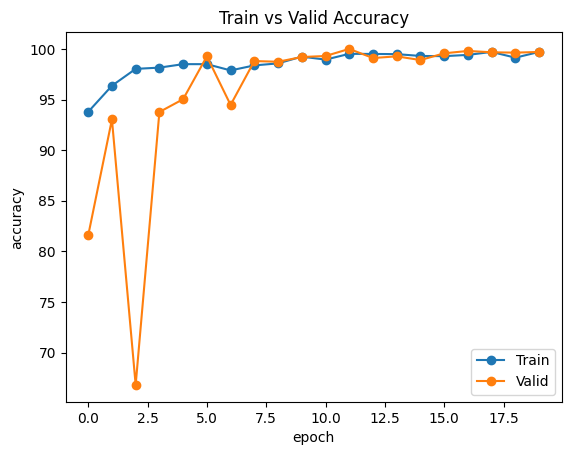

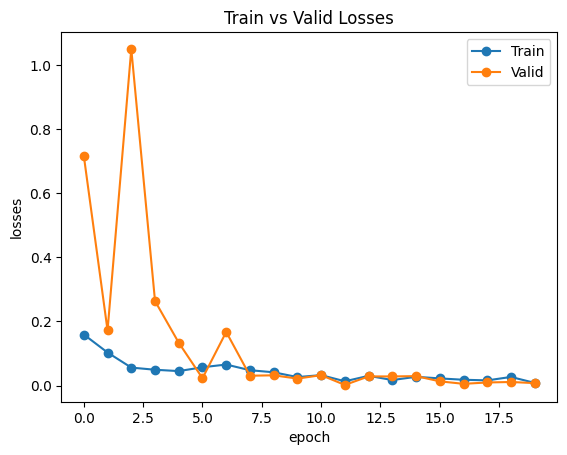

In [92]:
plt.plot(train_acc_gr,'-o')
plt.plot(val_acc_gr,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

plt.plot(train_loss_gr,'-o')
plt.plot(val_loss_gr,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
plt.show()

In [94]:
epoch_loss = 0
epoch_acc = 0
image_preds_all = []
image_targets_all = []

model1.eval()

with torch.no_grad():

    for (x, y) in tqdm(val_loader, desc="Evaluating", leave=False):

        x = x.to(device).float()
        y = y.to(device).long()

        y_pred = model1(x)

        image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
        image_targets_all += [y.detach().cpu().numpy()]

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

image_preds_all = np.concatenate(image_preds_all)
image_targets_all = np.concatenate(image_targets_all)
score = (image_preds_all==image_targets_all).mean()

performance_matrix(image_targets_all, image_preds_all)

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Precision: 0.9970 Recall: 0.9970, Accuracy: 0.9970: ,f1_score: 0.9970
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1000
           1       1.00      1.00      1.00      1000
           2       0.99      1.00      1.00      1000

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [95]:
# Assuming `predicted_class` is your tensor with predicted indices
labels = {0: 'Lung adenocarcinoma', 1: 'Lung benign tissue', 2: 'Lung squamous cell carcinoma'}


In [96]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [97]:
def predimg(imgdata):
    img = Image.open(imgdata)
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to('cuda')
    with torch.no_grad():
         model1.eval()
         predictions = model1(img_tensor)
    plt.imshow(img)
    predicted_class = torch.argmax(predictions, dim=1)
    predicted_index = predicted_class[0].item()
    print("Predicted class label:", labels[predicted_index])

Predicted class label: Lung adenocarcinoma


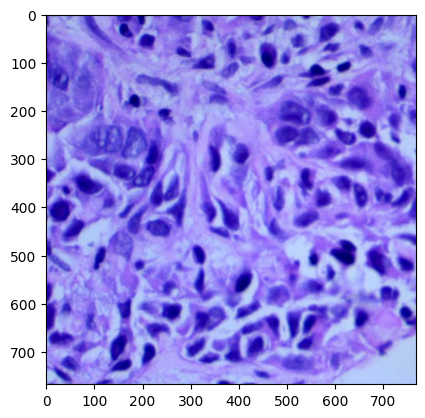

In [98]:
predimg("/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca4084.jpeg")

Predicted class label: Lung benign tissue


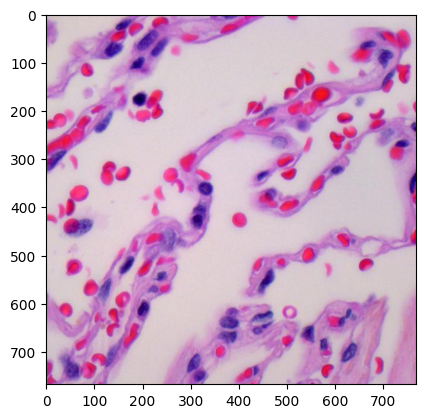

In [99]:
predimg("/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn4885.jpeg")

Predicted class label: Lung squamous cell carcinoma


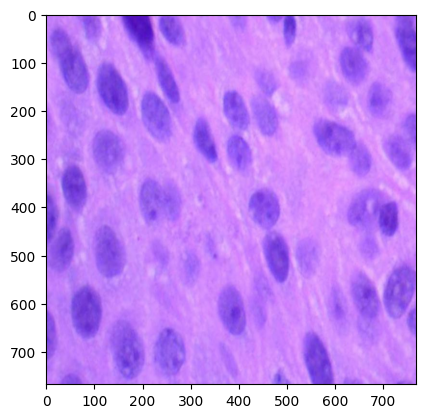

In [100]:
predimg("/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc/lungscc4787.jpeg")